In [377]:
from collections import defaultdict
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/pipelines/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

from bioomics import QueryComplex
from plot_region import PlotRegion
from layout import Layout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python310.zip', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/lib-dynload', '', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


In [368]:
# retrieve sequences
query = "select * from view_ab_dssp;"
seq_df = QueryComplex(True).list_data(query, True)
seq_df['specie'] = seq_df['specie'].map(lambda x: x.replace('_', ' '))
seq_df.head(3)

,pdb_id,chain_id,allele_name,specie,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq
0,3IJH,3IJH_0_A_0,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
1,3IJH,3IJH_0_B_0,IGHV7-3*02,Mus musculus,IGHV7-3,IGHV7,H,29.0730,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,"52.02,32.13,31.54,28.56,27.2,25.46,28.74,24.8,...",--EEEEE--EEE-TT--EEEEEEEESS-GGGS-EEEEEE-TTS--E...
2,3IJH,3IJH_0_C_0,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,34.2494,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"32.95,32.15,27.12,34.57,27.41,31.41,31.04,35.4...",--EEEE-SEEEEETTS-EEEEEEESS--EETTTTEE-EEEEEE-TT...


In [369]:
# IMGT regions
query = f"""select * from align_vregion
    where pdb_id in (
        select pdb_id from view_antibody
    )
;"""
vregion = QueryComplex(True).list_data(query, True)
vregion['seq_len'] = vregion['end'] - vregion['start'] + 1
vregion.head()

,pdb_id,chain_id,region_name,identity,start,end,seq,seq_len
0,3IJH,3IJH_0_A_0,FR1-IMGT,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0
1,3IJH,3IJH_0_A_0,CDR1-IMGT,100.0,26.0,37.0,QSLLNSRTRKNY,12.0
2,3IJH,3IJH_0_A_0,FR2-IMGT,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0
3,3IJH,3IJH_0_A_0,CDR2-IMGT,100.0,55.0,57.0,WAS,3.0
4,3IJH,3IJH_0_A_0,FR3-IMGT,100.0,58.0,93.0,TRESGVPDRFTGSGSGTDFTLTISSVQAEDLAVYYC,36.0


In [370]:
vregion['region_name'].value_counts()

region_name
Total        33343
FR2-IMGT     32769
FR3-IMGT     32441
CDR1-IMGT    32315
CDR2-IMGT    32292
FR1-IMGT     31969
CDR3-IMGT    29736
Name: count, dtype: int64

In [372]:
df = pd.merge(vregion, seq_df, how='left', on='chain_id')
df.head(3)

,pdb_id_x,chain_id,region_name,identity,start,end,seq,seq_len,pdb_id_y,allele_name,specie,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq
0,3IJH,3IJH_0_A_0,FR1-IMGT,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
1,3IJH,3IJH_0_A_0,CDR1-IMGT,100.0,26.0,37.0,QSLLNSRTRKNY,12.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
2,3IJH,3IJH_0_A_0,FR2-IMGT,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...


In [373]:
def region_bfactor(row):
    try:
        start, end = int(row['start'])-1, int(row['end'])
        if end > start:
            bfactors = row['bfactor'].split(',')
            return ','.join(bfactors[start:end])
    except Exception as e:
        pass
    return np.nan
df['region_bfactor'] = df.apply(region_bfactor, axis=1)

def region_avg_bfactor(row):
    try:
        start, end = int(row['start'])-1, int(row['end'])
        if end > start:
            bfactors = row['bfactor'].split(',')[start:end]
            return np.mean([float(i) for i in bfactors])
    except Exception as e:
        pass
    return np.nan
df['region_avg_bfactor'] = df.apply(region_avg_bfactor, axis=1)

def region_dssp(row):
    try:
        start, end = int(row['start'])-1, int(row['end'])
        if end > start:
            return row['dssp_seq'][start:end]
    except Exception as e:
        pass
    return np.nan
df['region_dssp'] = df.apply(region_dssp, axis=1)

/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [375]:
df.head(3)

,pdb_id_x,chain_id,region_name,identity,start,end,seq,seq_len,pdb_id_y,allele_name,...,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq,region_bfactor,region_avg_bfactor,region_dssp
0,3IJH,3IJH_0_A_0,FR1-IMGT,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",26.102400,--EEEE-SEEEEETT--EEEEEEES
1,3IJH,3IJH_0_A_0,CDR1-IMGT,100.0,26.0,37.0,QSLLNSRTRKNY,12.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"31.77,27.14,23.7,29.21,33.73,38.68,36.63,31.21...",29.497500,S--EETTTTEE-
2,3IJH,3IJH_0_A_0,FR2-IMGT,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"20.05,19.22,18.84,16.01,19.19,17.58,19.95,25.1...",20.887647,EEEEEE-TTS--EEEEE


## summary of regions

figure size: 8.5 x 6 cm


<Axes: title={'center': 'Heavy chain'}, xlabel='Length of region sequences'>

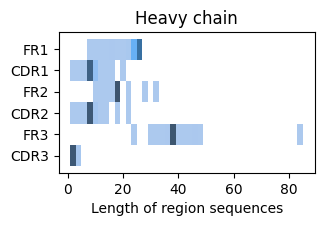

In [382]:
args = {'width_level': 1, 'height': 6}
fig, ax = Layout(args).one()

params = {'specie': 'Homo sapiens', 'chain_type': 'H', 'title': 'Heavy chain'}
PlotRegion(df).hist_region_len(ax, params)

figure size: 8.5 x 6 cm


<Axes: title={'center': 'Lambda chain'}, xlabel='Length of region sequences'>

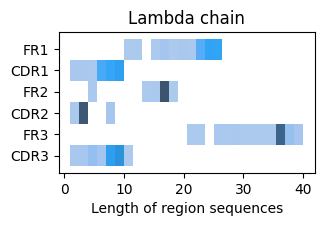

In [390]:
args = {'width_level': 1, 'height': 6}
fig, ax = Layout(args).one()

params = {'specie': 'Homo sapiens', 'chain_type': 'L', 'title': 'Lambda chain'}
PlotRegion(df).hist_region_len(ax, params)

figure size: 8.5 x 6 cm


<Axes: title={'center': 'Kappa chain'}, xlabel='Length of region sequences'>

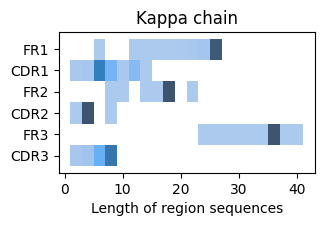

In [385]:
args = {'width_level': 1, 'height': 6}
fig, ax = Layout(args).one()

params = {'specie': 'Homo sapiens', 'chain_type': 'K', 'title': 'Kappa chain'}
PlotRegion(df).hist_region_len(ax, params)

figure size: 17.4 x 6 cm


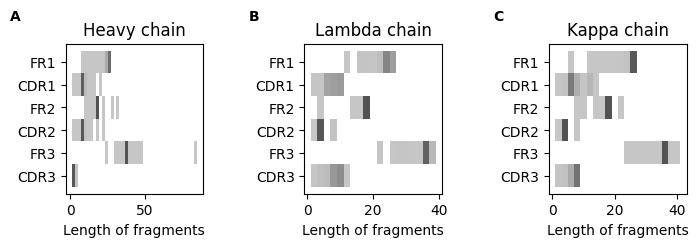

In [519]:
args = {'width_level': 3, 'height': 6, 'space': .2}
label_x = (-40,) * 3
label_y = 25
fig, axes = Layout(args).row(label_x, label_y)

specie = 'Homo sapiens'
params = {'specie': specie, 'chain_type': 'H', 'title': 'Heavy chain'}
PlotRegion(df).hist_region_len(axes[0], params)
params = {'specie': specie, 'chain_type': 'L', 'title': 'Lambda chain'}
PlotRegion(df).hist_region_len(axes[1], params)
params = {'specie': specie, 'chain_type': 'K', 'title': 'Kappa chain'}
PlotRegion(df).hist_region_len(axes[2], params)

fig.savefig(f'{specie}_vregion_fragment.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

## dssp

In [409]:
sdf = df[(df['specie']==specie) & (df['region_name'].str.contains('IMGT'))]
cols = ['chain_type', 'region_name', 'avg_bfactor', 'region_avg_bfactor']
sdf = sdf[cols]
sdf['region_name'] = sdf['region_name'].map(lambda x: x.replace('-IMGT', ''))
sdf

,chain_type,region_name,avg_bfactor,region_avg_bfactor
0,K,FR1,27.2235,26.102400
1,K,CDR1,27.2235,29.497500
2,K,FR2,27.2235,20.887647
3,K,CDR2,27.2235,21.450000
4,K,FR3,27.2235,23.174444
...,...,...,...,...
250187,K,CDR1,71.5431,31.627273
250188,K,FR2,71.5431,28.470588
250189,K,CDR2,71.5431,25.100000
250190,K,FR3,71.5431,32.692778


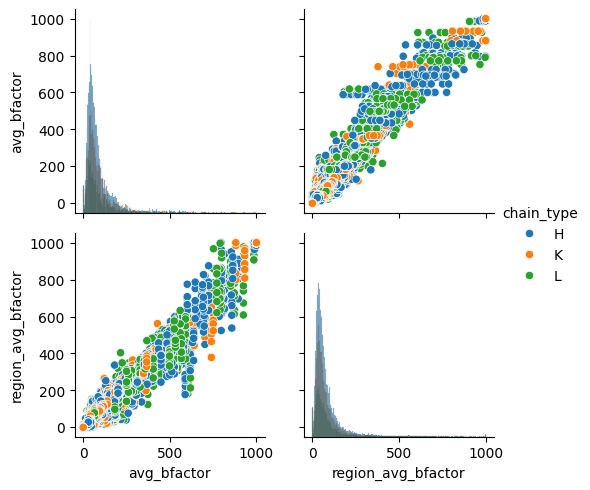

In [175]:
g = sns.PairGrid(sdf, hue='chain_type')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

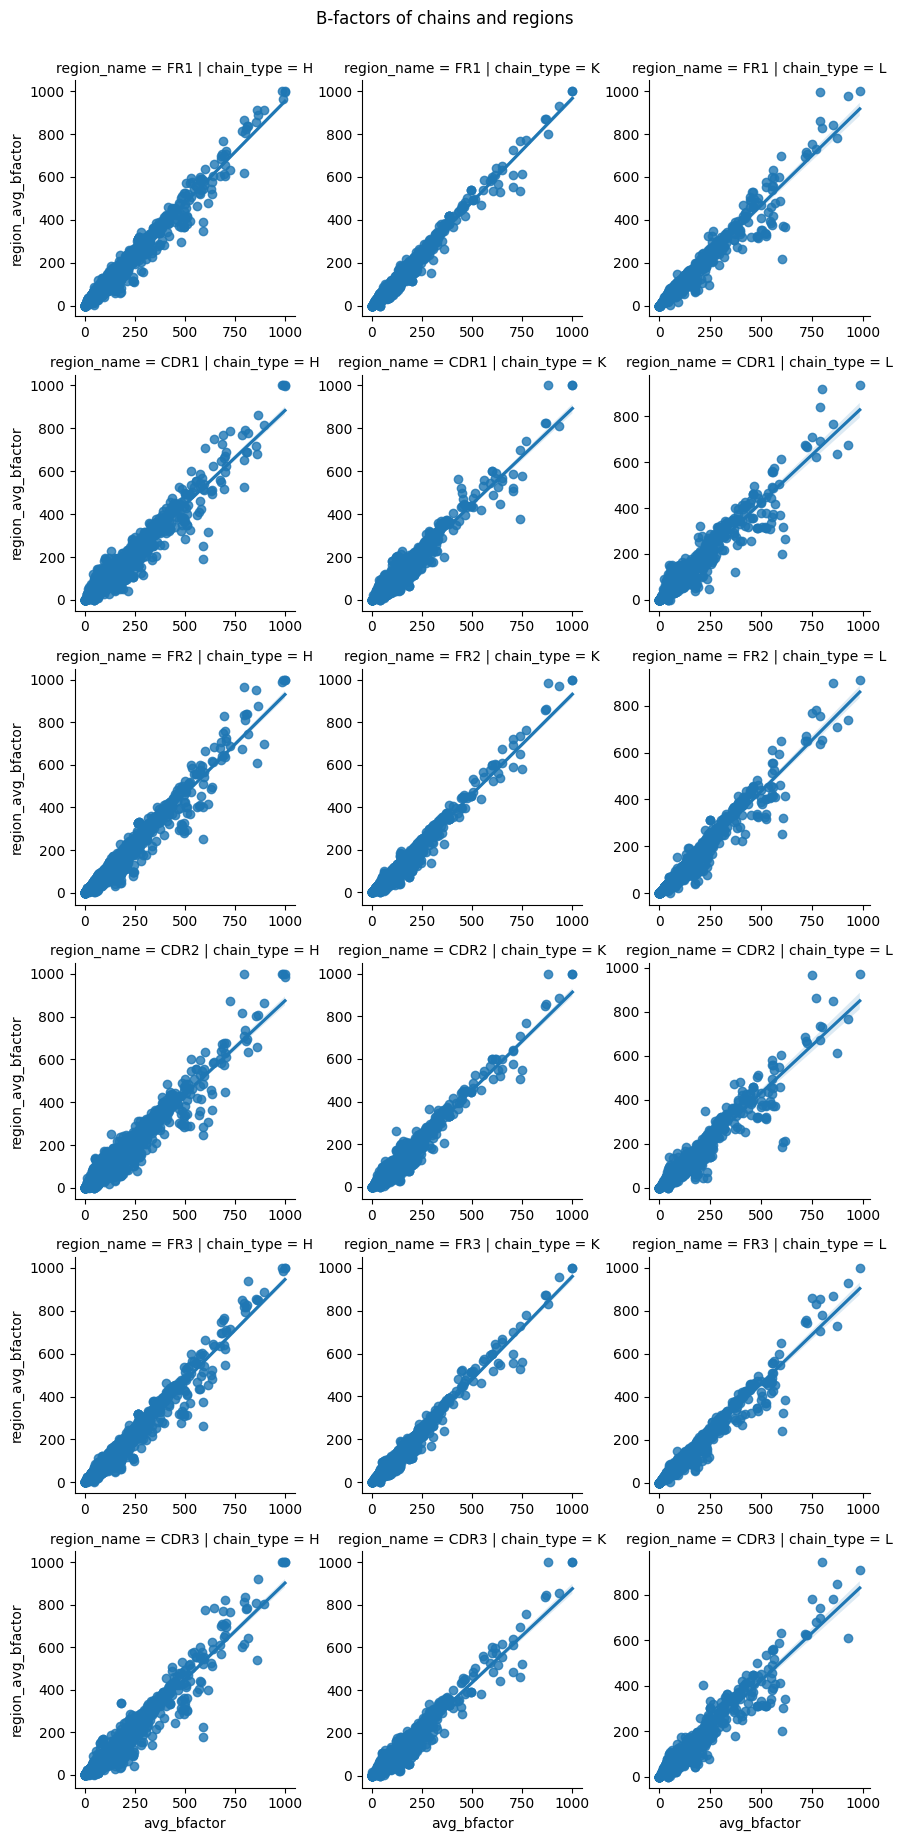

In [214]:
# Create the regression plots with facets
g = sns.lmplot(data=sdf, x="avg_bfactor", y="region_avg_bfactor",
    col="chain_type", row="region_name",
    height=3, facet_kws=dict(sharex=False, sharey=False),
)
g.fig.suptitle("B-factors of chains and regions", y=1.02)

plt.show()

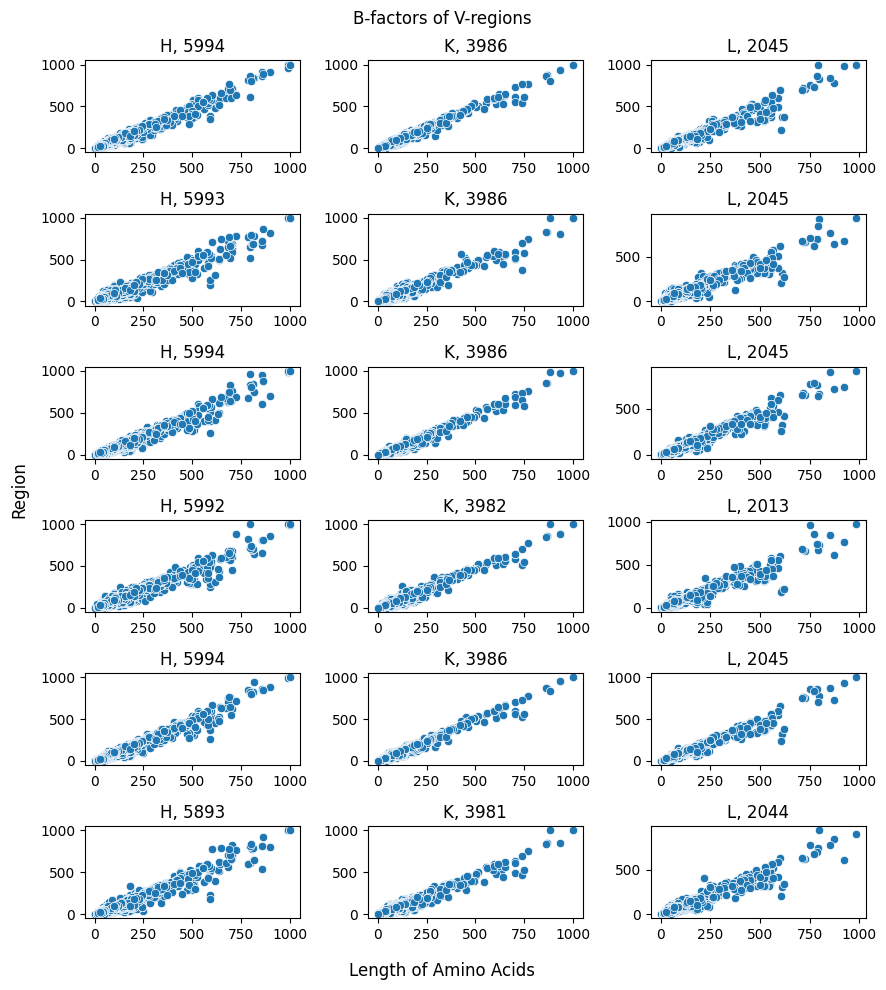

In [177]:
fig, ax = plt.subplots(6,3, figsize=(9,10), layout='tight')
fig.suptitle("B-factors of V-regions")
fig.supxlabel('Length of Amino Acids')
fig.supylabel('Region')

region_names = sdf['region_name'].unique()
chain_types = sdf['chain_type'].unique()
for i, region_name in enumerate(region_names):
    for j, chain_type in enumerate(chain_types):
        sub = sdf[(sdf['region_name']==region_name)&(sdf['chain_type']==chain_type)]
        sns.scatterplot(sub, x='avg_bfactor', y='region_avg_bfactor', ax=ax[i][j])
        ax[i][j].set_title(f"{chain_type}, {len(sub)}")
        ax[i][j].set_xlabel(None)
        ax[i][j].set_ylabel(None)
plt.show()

## secondary structure

In [495]:
chain_types = {'H':'Heavy', 'K':'Kappa', 'L':'Lambda',}
DSSP_CODES ={
    'H': 'alpha helix',
    'B': 'beta bridge', #isolated beta bridge
    'E': 'beta sheet',
    'S': 'bend',  #local, sharp turn 
    'G': '310 helix',
    'I': 'Pi helix',
    'T': 'turn', #hydrogen-bonded turn
    'C': 'coil',
    '-': 'loop',
} 

In [496]:
pool = []
for i, row in df.iterrows():
    try:
        basic = {
            'region_name': row['region_name'].replace('-IMGT', ''),
            'specie': row['specie'],
            'chain_type': chain_types.get(row['chain_type']),
        }
        if 'IMGT' in row['region_name']:
            region_bfactor = row['region_bfactor'].split(',')
            region_dssp = list(row['region_dssp'])
            for b, d in zip(region_bfactor, region_dssp):
                rec = {
                    'bfactor': float(b),
                    'dssp': DSSP_CODES.get(d, 'loop'),
                }
                rec.update(basic)
                pool.append(rec)
    except Exception as e:
        pass
ddf = pd.DataFrame(pool)

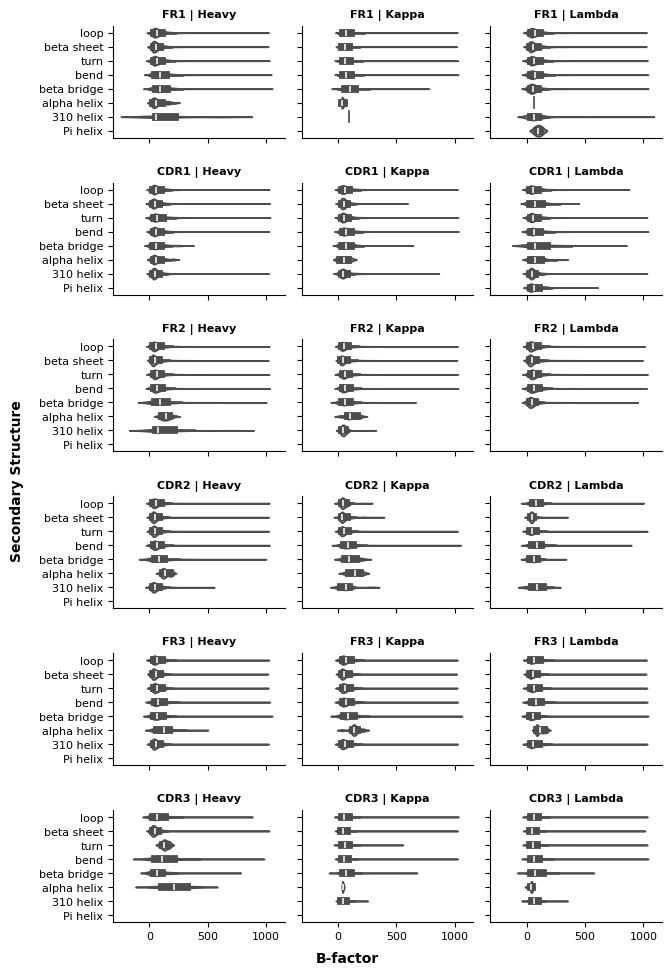

In [516]:
# B-factor distribution
specie = "Homo sapiens"
sddf = ddf[ddf['specie']==specie]

g = sns.FacetGrid(sddf, col='chain_type', row='region_name')
g.map_dataframe(sns.violinplot, y='dssp', x='bfactor', color='grey')
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=8, fontweight='bold')
g.set(xlabel=None, ylabel=None)
g.fig.text(0.5, -0.01, 'B-factor', ha='center', rotation='horizontal', fontsize=10, fontweight='bold')
g.fig.text(-.02, 0.5, 'Secondary Structure', va='center', rotation='vertical', fontsize=10, fontweight='bold')
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=8)

g.fig.subplots_adjust(hspace=.4, wspace=.1)
g.fig.set_size_inches(16.5/2.54, 24/2.54)
g.savefig(f'{specie}_dssp_bfactor_distribution.tif', dpi=300)

### percentage of DSSP in fragements of v-region

In [498]:
dssp_pool = {}
len_pool = {}
for i, row in df.iterrows():
    try:
        if 'IMGT' in row['region_name']:
            region_name = row['region_name'].replace('-IMGT', '')
            specie = row['specie']
            chain_type = chain_types.get(row['chain_type'])
            seq_len = len(row['seq'])
            key = (specie, chain_type, region_name)
            if key not in len_pool:
                len_pool[key] = {}
            if 'total_len' not in len_pool[key]:
                len_pool[key]['total_len'] = 0
            if 'num_chain' not in len_pool[key]:
                len_pool[key]['num_chain'] = 0
            len_pool[key]['total_len'] += seq_len
            len_pool[key]['num_chain'] += 1
            if 'IMGT' in row['region_name']:
                region_dssp = list(row['region_dssp'])
                for d in region_dssp:
                    d = DSSP_CODES.get(d, 'loop')
                    if key not in dssp_pool:
                        dssp_pool[key]= {}
                    if d not in dssp_pool[key]:
                        dssp_pool[key][d] = 0
                    dssp_pool[key][d] +=1
    except Exception as e:
        # print(e)
        pass

In [499]:
gdf1 = pd.DataFrame.from_dict(dssp_pool, orient='index')
gdf2 = pd.DataFrame.from_dict(len_pool, orient='index')
gdf2 = gdf2.loc[gdf1.index]
gdf = gdf1.div(gdf2['total_len'], axis=0)*100
gdf = gdf.fillna(0)
gdf = gdf.stack().reset_index()
gdf.columns = ['specie','chain_type','region_name', 'structure', 'percent']
gdf = gdf.sort_values(['specie','chain_type',])
gdf.head()

,specie,chain_type,region_name,structure,percent
328,Bos taurus,Heavy,FR1,loop,23.398480
329,Bos taurus,Heavy,FR1,beta sheet,56.460369
330,Bos taurus,Heavy,FR1,bend,12.595005
331,Bos taurus,Heavy,FR1,turn,7.166124
332,Bos taurus,Heavy,FR1,beta bridge,0.380022


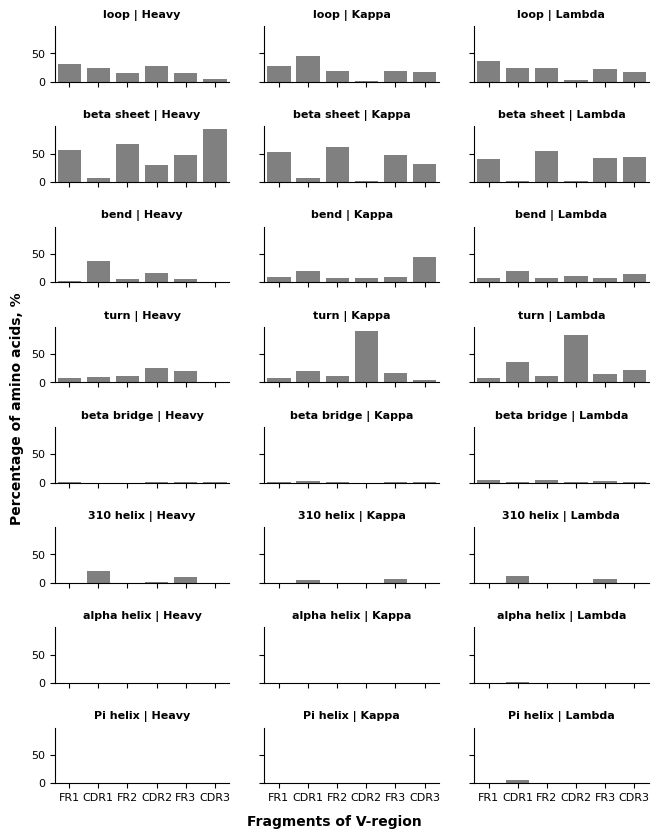

In [517]:
specie = 'Homo sapiens'
sgdf = gdf[gdf['specie']==specie]
g = sns.FacetGrid(sgdf, col='chain_type', row='structure')
g.map(sns.barplot, 'region_name', 'percent', order=['FR1', 'CDR1','FR2', 'CDR2','FR3', 'CDR3'], color='grey')
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=8, fontweight='bold')
g.set(xlabel=None, ylabel=None)
g.fig.text(0.5, -.03, 'Fragments of V-region', ha='center', rotation='horizontal', fontsize=10, fontweight='bold')
g.fig.text(0, 0.5, 'Percentage of amino acids, %', va='center', rotation='vertical', fontsize=10, fontweight='bold')
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=8)
    
g.fig.subplots_adjust(wspace=.2, hspace=.8)
g.fig.set_size_inches(16.5/2.54, 20/2.54)
g.savefig(f'{specie}_dssp_percent.tif', dpi=300)

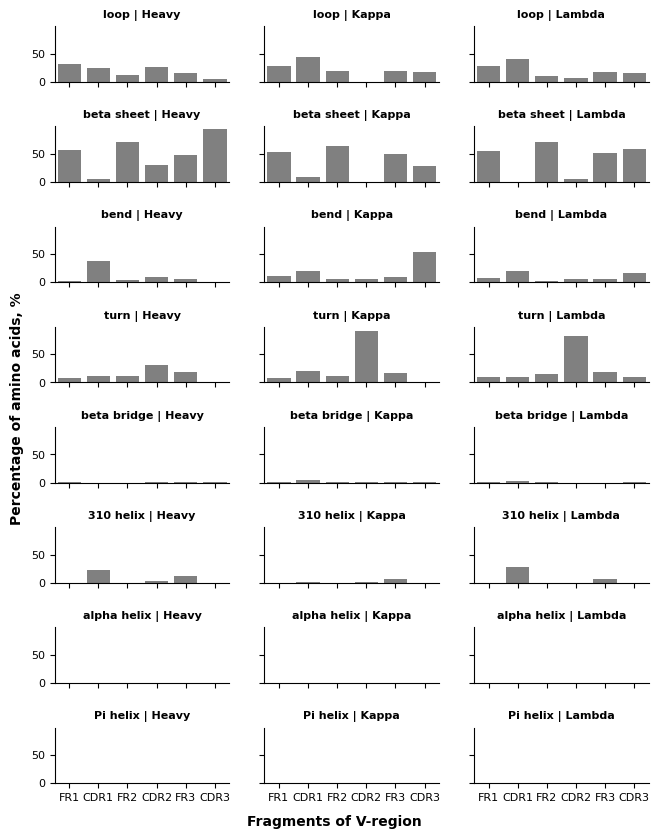

In [518]:
specie = 'Mus musculus'
sgdf = gdf[gdf['specie']==specie]
g = sns.FacetGrid(sgdf, col='chain_type', row='structure')
g.map(sns.barplot, 'region_name', 'percent', order=['FR1', 'CDR1','FR2', 'CDR2','FR3', 'CDR3'], color='grey')
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=8, fontweight='bold')
g.set(xlabel=None, ylabel=None)
g.fig.text(0.5, -.03, 'Fragments of V-region', ha='center', rotation='horizontal', fontsize=10, fontweight='bold')
g.fig.text(0, 0.5, 'Percentage of amino acids, %', va='center', rotation='vertical', fontsize=10, fontweight='bold')
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=8)
    
g.fig.subplots_adjust(wspace=.2, hspace=.8)
g.fig.set_size_inches(16.5/2.54, 20/2.54)
g.savefig(f'{specie}_dssp_percent.tif', dpi=300)